In [69]:
# pip install pyautogluon

# Import

In [70]:
import pandas as pd
import numpy as np
import random
import os
import gc

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None  # default='warn'

from autogluon.tabular import TabularPredictor, TabularDataset

In [71]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(42) # Seed 고정

# Data Load

In [72]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv', index_col = 0)

# Data Pre-Processing

In [73]:
train_x = train[['Exercise_Duration', 'Gender','BPM','Age','Weight(lb)']]
train_y = train['Calories_Burned']
test_x = test[['Exercise_Duration', 'Gender','BPM','Age','Weight(lb)']]

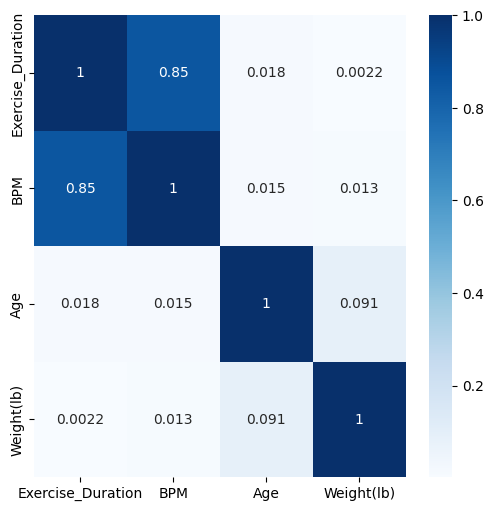

In [74]:
plt.figure(figsize = (6,6))
sns.heatmap(train_x.corr(), annot = True, cmap = 'Blues')
plt.show()

In [75]:
ordinal_features = ['Gender']
for feature in ordinal_features:
    le = LabelEncoder()
    le = le.fit(train_x[feature])
    train_x[feature] = le.transform(train_x[feature])
    for label in np.unique(test_x[feature]):
        if label not in le.classes_:
            le.classes_ = np.append(le.classes_, label)
    test_x[feature] = le.transform(test_x[feature])

In [76]:
Train = train_x.copy()
Y = train_y.copy()
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.1, random_state=41, shuffle=True)

# Regression Model (With Validation)

In [77]:
poly3 = PolynomialFeatures(degree=3, interaction_only=True)
poly3.fit(train_x)

train_x3 = pd.DataFrame(poly3.transform(train_x))
val_x3 = pd.DataFrame(poly3.transform(val_x))

LR = LinearRegression() # LinearRegression
LR.fit(train_x3, train_y)
pred = LR.predict(val_x3)

mean_squared_error(val_y, pred, squared=False)

0.2839894748134119

In [78]:
mean_squared_error(val_y, np.round(pred), squared=False)

0.09660917830792959

In [79]:
ridge = Ridge()  # Ridge
ridge.fit(train_x3, train_y)
pred = ridge.predict(val_x3)

mean_squared_error(val_y, pred, squared=False)

0.2836201472339451

In [80]:
mean_squared_error(val_y, np.round(pred), squared=False)

0.11547005383792516

# Regression Model Fit (No Validation)

In [81]:
poly3 = PolynomialFeatures(degree=3, interaction_only=True)
poly3.fit(Train)
train_x3 = pd.DataFrame(poly3.transform(Train))
train_y = Y

In [82]:
LR = LinearRegression()
LR.fit(train_x3, train_y)

ridge = Ridge()
ridge.fit(train_x3, train_y)

pred_train_LR_3 = pd.DataFrame(LR.predict(train_x3)).rename({0:'LR'}, axis=1)
pred_train_ridge_3 = pd.DataFrame(ridge.predict(train_x3)).rename({0:'Ridge'}, axis=1)

In [83]:
new_train = pd.concat([pred_train_LR_3, pred_train_ridge_3], axis=1)
train_y = pd.DataFrame(train_y).reset_index(drop=True)
new_train['Calories_Burned']=train_y
new_train = np.round(new_train)

new_train.isnull().any()

LR                 False
Ridge              False
Calories_Burned    False
dtype: bool

In [84]:
# Stacking using autogluon
stacking = TabularPredictor(label='Calories_Burned', eval_metric='rmse', problem_type='regression').fit(new_train, presets=['best_quality'], num_stack_levels=0)

No path specified. Models will be saved in: "AutogluonModels\ag-20230424_192852\"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=8, num_bag_sets=1
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20230424_192852\"
AutoGluon Version:  0.7.0
Python Version:     3.10.10
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
Train Data Rows:    7500
Train Data Columns: 2
Label Column: Calories_Burned
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    9750.55 MB
	Train Data (Original)  Memory Usage: 0.12 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeat

In [89]:
ld = stacking.leaderboard(silent=True)
LD = ld[['model', 'score_val']].rename({'score_val':'RMSE'},axis=1)
LD['RMSE'] = -LD['RMSE']
LD.head()

,model,RMSE
0,WeightedEnsemble_L2,0.147141
1,ExtraTreesMSE_BAG_L1,0.150657
2,RandomForestMSE_BAG_L1,0.159065
3,KNeighborsDist_BAG_L1,0.197509
4,KNeighborsUnif_BAG_L1,0.272646


# Inference

In [86]:
test3 = poly3.transform(test_x)

Pred1 = pd.DataFrame(LR.predict(test3)).rename({0:'LR'}, axis=1)
Pred2 = pd.DataFrame(ridge.predict(test3)).rename({0:'Ridge'},axis=1)

Pred1 = np.round(Pred1)
Pred2 = np.round(Pred2)

# Submit

In [87]:
# Voting Submission
pred = 0.6*Pred1['LR'] + 0.4*Pred2['Ridge']
sample_submission['Calories_Burned'] = np.array(pred)
sample_submission.to_csv('PolynomialFeatures_Voting.csv', index = True)
sample_submission

,Calories_Burned
ID,
TEST_0000,173.0
TEST_0001,189.0
TEST_0002,53.0
TEST_0003,161.0
TEST_0004,226.0
...,...
TEST_7495,197.0
TEST_7496,10.0
TEST_7497,130.0


In [88]:
# Stacking Submission
NEW = pd.concat([Pred1, Pred2], axis=1)
Pred = stacking.predict(NEW, model = 'WeightedEnsemble_L2')

sample_submission['Calories_Burned'] = np.array(Pred)
sample_submission.to_csv('PolynomialFeatures_Stacking.csv', index = True)
sample_submission

,Calories_Burned
ID,
TEST_0000,172.995987
TEST_0001,188.997849
TEST_0002,52.996548
TEST_0003,160.996048
TEST_0004,225.991196
...,...
TEST_7495,197.041733
TEST_7496,10.014333
TEST_7497,129.992798
